In [6]:
import pandas as pd
import numpy as np

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score,log_loss,accuracy_score
from sklearn.metrics import confusion_matrix,recall_score,precision_score
from sklearn.preprocessing import binarize,PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import binarize

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [8]:
def encoder(dataset,catFeatures,qtyFeatures):
  dataset=dataset[catFeatures+qtyFeatures]
  dataset_encoded=pd.get_dummies(dataset,columns=catFeatures,drop_first=True)
  return(dataset_encoded)

def plot_auc_curve(model, x, y):
    try:
        y_pred_prob = model.predict_proba(x)[:, 1]
    except AttributeError:
        d = model.decision_function(x)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))

    auc = roc_auc_score(y, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve\nAUC={}'.format(auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid(True)

def model_training(model,x,y):
  model.fit(x,y)
  return(model)

def print_accuracy_metrics(model, x, y, threshold):
    try:
        y_pred_prob = model.predict_proba(x)[:, 1]
    except AttributeError:
        d = model.decision_function(x)
        y_pred_prob = np.exp(d) / (1 + np.exp(d))

    y_pred_class = (y_pred_prob > threshold).astype(int)

    print("Accuracy:", accuracy_score(y, y_pred_class))
    print("AUC:", roc_auc_score(y, y_pred_prob))
    print("Log Loss:", log_loss(y, y_pred_prob))
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
    print("Recall:", recall_score(y, y_pred_class))
    print("Precision:", precision_score(y, y_pred_class))

def Find_Optimal_Cutoff(model,x,y):
  try:
    y_pred_prob=model.predict_proba(x)[:,1]
  except:
    d=model.decision_function(x)
    y_pred_prob=np.exp(d) / (1+ np.exp(d))
  fpr,tpr,threshold=roc_curve(y,y_pred_prob)
  i=np.arange(len(tpr))
  roc = pd.DataFrame({'tf': pd.Series(tpr - (1 - fpr), index=i), 'threshold': pd.Series(threshold, index=i)})
  roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
  print("optimal cutoff",roc_t['threshold'].values)
  return(roc_t['threshold'].sort_values)

def feature_importance(model,x):
  importances=model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

  indices=np.argsort(importances)[::-1]

  print("Feature ranking:")

  for f in range(x.shape[1]):
    print("%d. %s (%f)" % (f+1,x.columns[indices[f]],importances[indices[f]]))

  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(x.shape[1]),importances[indices],color="r",yerr=std[indices],align="center")
  plt.xticks(range(x.shape[1]),indices)
  plt.xlim([-1,x.shape[1]])
  plt.show()

def plot_calibration(y_true,y_prob,n_bins,model_name):
  plt.figure(figsize=(10,30))
  ax1=plt.subplot2grid((3,1),(0,0),rowspan=2)
  ax2=plt.subplot2grid((3,1),(2,0))

  ax1.plot([0,1],[0,1],"k:",label="Perfectly calibrated")
  fraction_of_positives,mean_predicted_value=calibration_curve(y_true,y_prob,n_bins=n_bins)

  ax1.plot(mean_predicted_value,fraction_of_positives,"s-",label="%s" % (model_name, ))

  ax2.hist(y_pred_prob,range=(0,1),bins=10,label=model_name,histtype="step",lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05,1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right",ncol=2)

  plt.tight_layout()
  plt.show()


In [11]:
file_url='/bank_loan_predict_train.csv'
df=pd.read_csv(file_url)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [12]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [13]:
df.shape

(614, 13)

In [14]:
df.groupby('Loan_Status')['Loan_ID'].count()

Loan_Status
N    192
Y    422
Name: Loan_ID, dtype: int64

In [15]:
loanIDCount=df.groupby('Loan_ID')['Loan_Status'].count()
loanIDCount= loanIDCount.sort_values(ascending=False)
loanIDCount[0:5]

Loan_ID
LP001002    1
LP002328    1
LP002305    1
LP002308    1
LP002314    1
Name: Loan_Status, dtype: int64

In [16]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [17]:
catFeatures = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area',  'Loan_Status']
qtyFeatures = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Loan_Amount_Term']
x_encoded=encoder(df,catFeatures,qtyFeatures)
le=LabelEncoder()
label = 'Loan_Status'
y_encoded=le.fit_transform(df[label])

In [18]:
x_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
0,5849,0.0,NaN,360.0,1,0,0,0,0,0,0,0,1,1
1,4583,1508.0,128.0,360.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1,0,0,0,0,0,0,0,1,1


In [19]:
y_encoded

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,

LOGISTIC REGRESSION

In [46]:
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform on your data
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.fit_transform(x_test)




In [21]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [22]:
from sklearn.impute import SimpleImputer

# Impute missing values in categorical columns with the most frequent value (mode)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])

# Impute missing values in numerical columns with the mean
numerical_columns = ['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome']
imputer_numerical = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer_numerical.fit_transform(df[numerical_columns])


In [23]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [44]:
x_train,x_test,y_train,y_test=train_test_split(x_encoded,y_encoded,test_size=0.2,random_state=1)

In [25]:
print(len(x_train), len(y_train))  # Check lengths of x_train and y_train
print(len(x_test), len(y_test))    # Check lengths of x_test and y_test


491 491
123 123


In [26]:
# Check for NaN values in x_train and x_test
print(x_train.isnull().sum())
print(x_test.isnull().sum())


ApplicantIncome             0
CoapplicantIncome           0
LoanAmount                 17
Loan_Amount_Term           10
Gender_Male                 0
Married_Yes                 0
Dependents_1                0
Dependents_2                0
Dependents_3+               0
Education_Not Graduate      0
Self_Employed_Yes           0
Property_Area_Semiurban     0
Property_Area_Urban         0
Loan_Status_Y               0
dtype: int64
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 5
Loan_Amount_Term           4
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_Y              0
dtype: int64


In [47]:
from sklearn.impute import SimpleImputer

# Define columns with missing values in both x_train and x_test
numerical_columns_with_missing = ['LoanAmount', 'Loan_Amount_Term']

# Impute missing values in numerical columns with appropriate strategies
imputer = SimpleImputer(strategy='mean')  # Use 'mean' for LoanAmount
x_train[numerical_columns_with_missing] = imputer.fit_transform(x_train[numerical_columns_with_missing])
x_test[numerical_columns_with_missing] = imputer.transform(x_test[numerical_columns_with_missing])

# For Loan_Amount_Term, you might use the mode instead of mean, if appropriate
imputer_mode = SimpleImputer(strategy='most_frequent')
x_train['Loan_Amount_Term'] = imputer_mode.fit_transform(x_train[['Loan_Amount_Term']])
x_test['Loan_Amount_Term'] = imputer_mode.transform(x_test[['Loan_Amount_Term']])


In [48]:
print(x_train.isnull().sum())
print(x_test.isnull().sum())


ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_Y              0
dtype: int64
ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Loan_Amount_Term           0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Property_Area_Semiurban    0
Property_Area_Urban        0
Loan_Status_Y              0
dtype: int64


In [29]:
print(x_test.shape)
print(y_test.shape)


(123, 14)
(123,)


optimal cutoff [0.93753787]
Accuracy: 1.0
AUC: 1.0
Log Loss: 0.03132735617004685
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


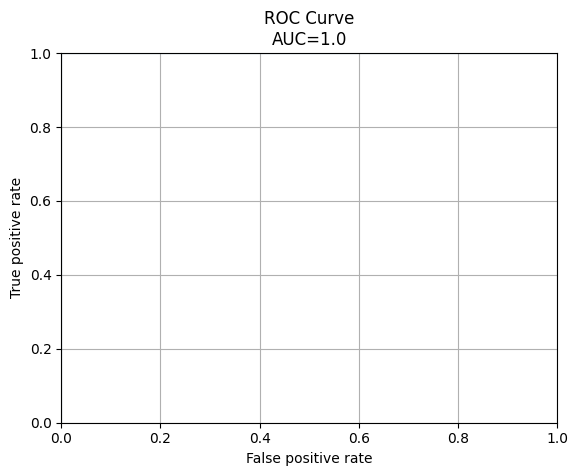

In [30]:
logreg=LogisticRegression()
model_training(logreg,x_train,y_train)

plot_auc_curve(logreg,x_test,y_test)
Find_Optimal_Cutoff(logreg,x_test,y_test)
print_accuracy_metrics(logreg,x_test,y_test,0.65)

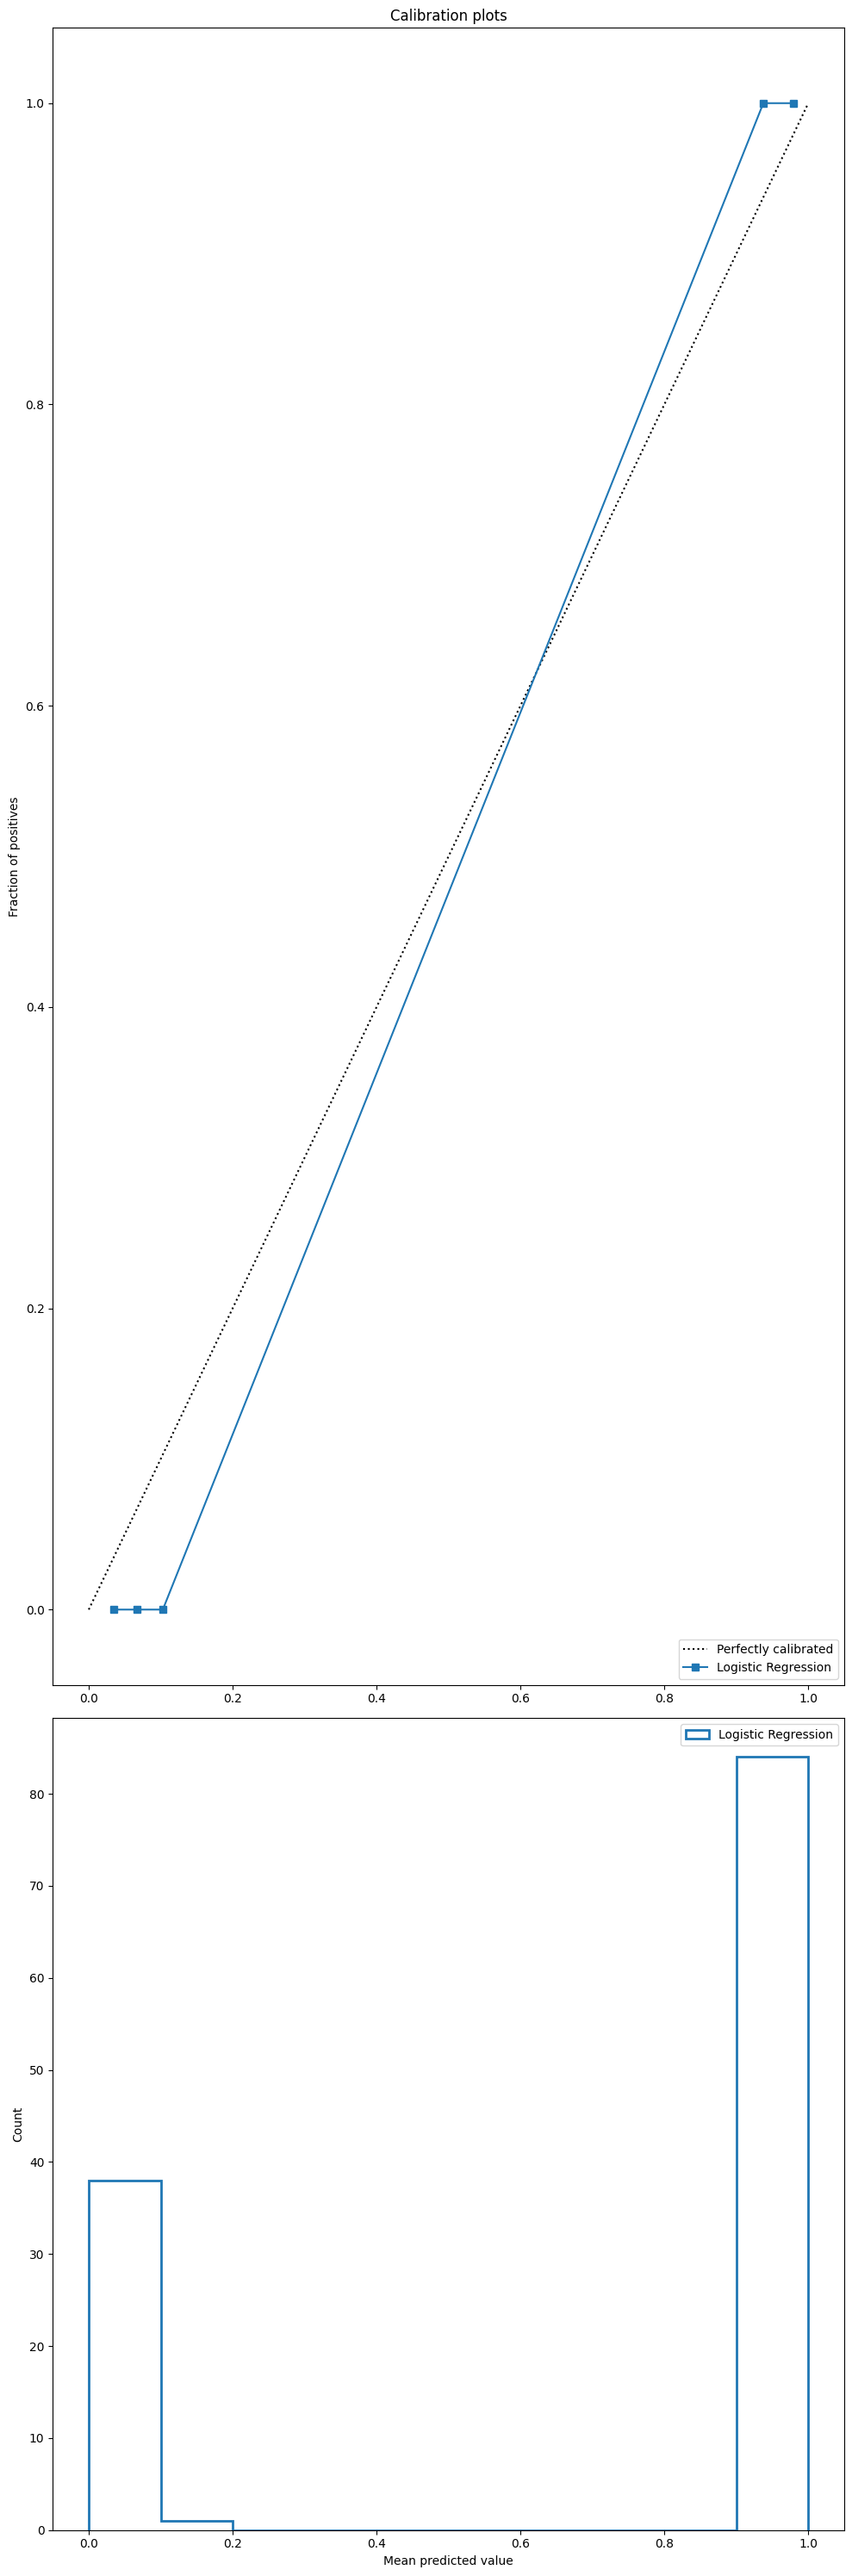

In [ ]:
y_pred_prob=logreg.predict_proba(x_test)[:,1]
plot_calibration(y_test,y_pred_prob,20,"Logistic Regression")

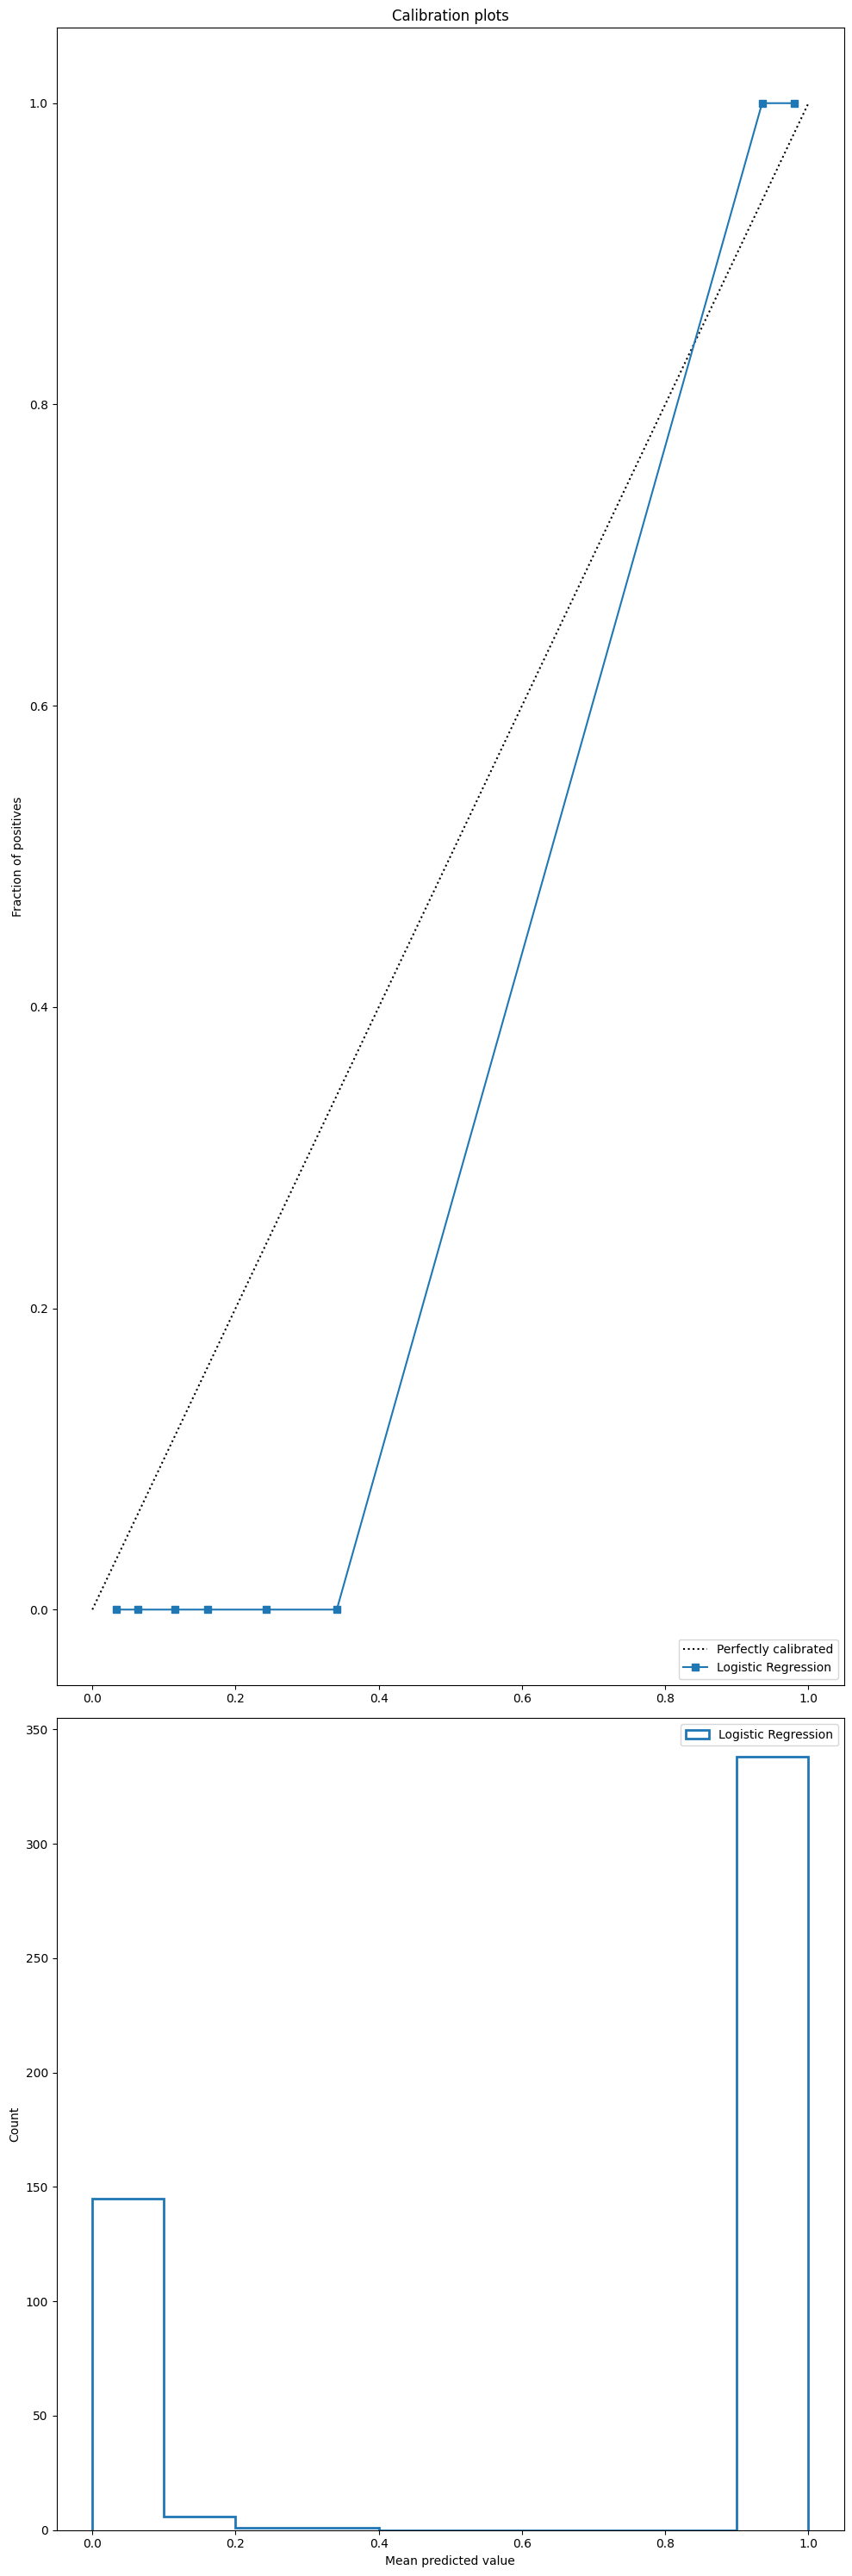

In [ ]:
y_pred_prob=logreg.predict_proba(x_train)[:,1]
plot_calibration(y_train,y_pred_prob,20,"Logistic Regression")

In [31]:
print_accuracy_metrics(logreg,x_train,y_train,0.65)

Accuracy: 1.0
AUC: 1.0
Log Loss: 0.03078581890258882
Confusion Matrix:
 [[153   0]
 [  0 338]]
Recall: 1.0
Precision: 1.0


RIDGE REGRESSION

optimal cutoff [0.72909741]
Accuracy: 1.0
AUC: 1.0
Log Loss: 0.3154878366068807
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


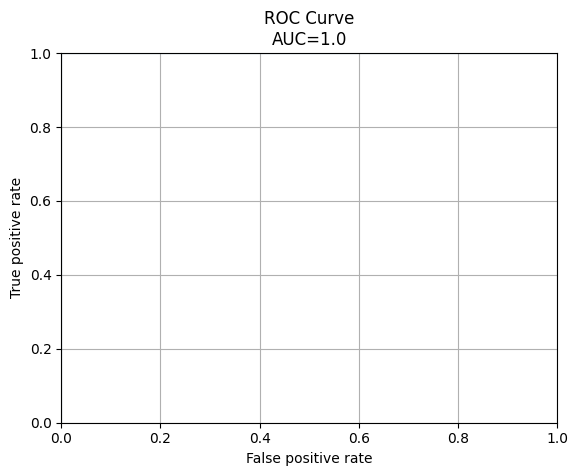

In [32]:
ridge=RidgeClassifier(alpha=1.0)
model_training(ridge,x_train,y_train)

plot_auc_curve(ridge,x_test,y_test)
Find_Optimal_Cutoff(ridge,x_test,y_test)
print_accuracy_metrics(ridge,x_test,y_test,0.65)

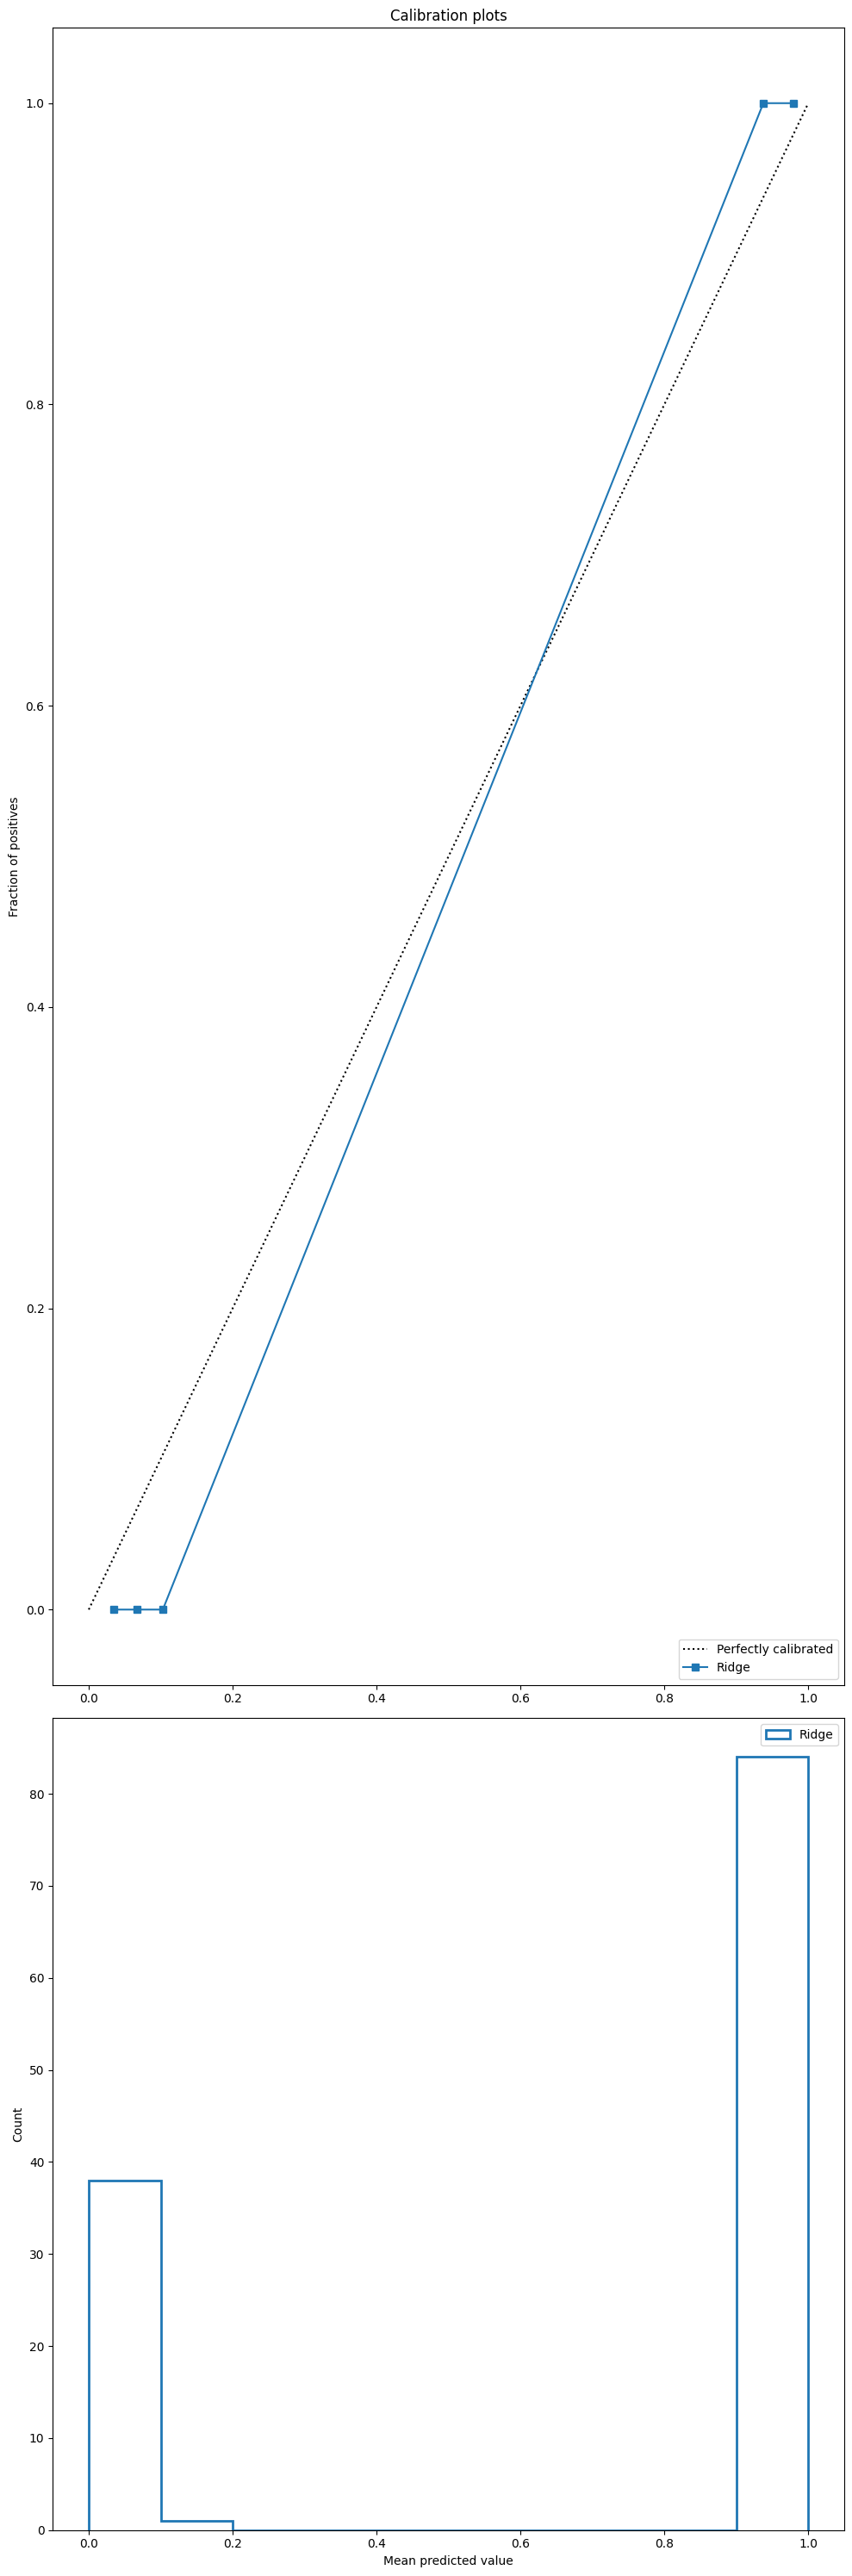

In [ ]:
y_pred_prob=logreg.predict_proba(x_test)[:,1]
plot_calibration(y_test,y_pred_prob,20,"Ridge")

L2 REGULARISATION

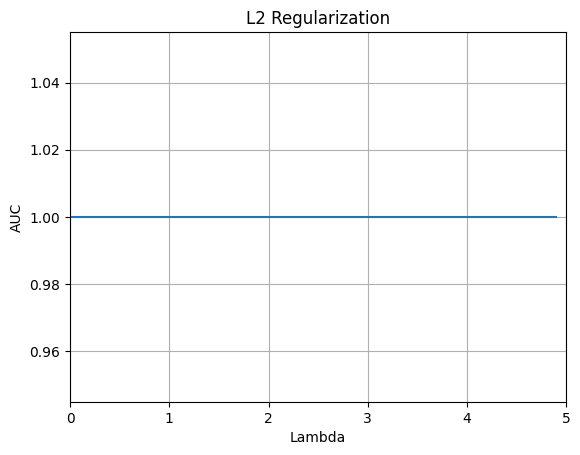

In [33]:
alpha_range=np.arange(0.001,5,0.1)
scores=[]
for lam in alpha_range:
  ridge=RidgeClassifier(alpha=lam)
  scores.append(cross_val_score(ridge,x_train,y_train,cv=5,scoring='roc_auc').mean())

plt.plot(alpha_range,scores)
plt.xlim([0.0,5])
plt.title('L2 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

In [ ]:
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

L1 REGULARISATION (LASSO)

optimal cutoff [0.93753787]
Accuracy: 1.0
AUC: 1.0
Log Loss: 0.03132735617004685
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


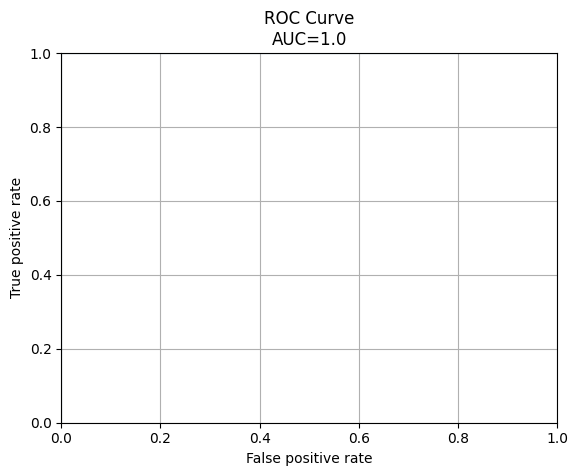

In [34]:
lasso=LogisticRegression(penalty='l2',C=1)
model_training(lasso,x_train,y_train)

plot_auc_curve(lasso,x_test,y_test)
Find_Optimal_Cutoff(lasso,x_test,y_test)
print_accuracy_metrics(lasso,x_test,y_test,0.73)

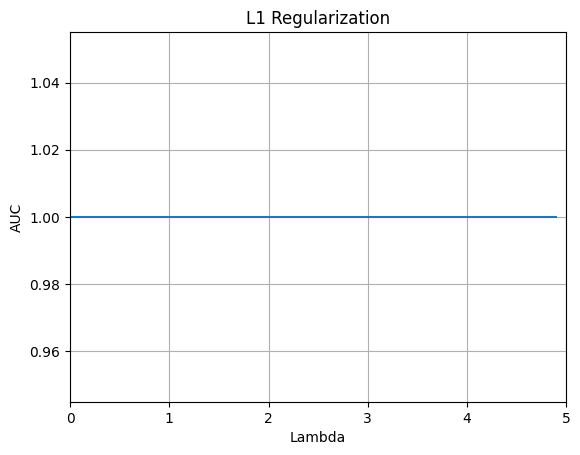

In [35]:
lambda_range=np.arange(0.001,5,0.1)
scores=[]
for lam in lambda_range:
  lasso=LogisticRegression(penalty='l2',C=1/lam)
  scores.append(cross_val_score(lasso,x_train,y_train,cv=5,scoring='roc_auc').mean())
plt.plot(lambda_range,scores)
plt.xlim([0.0,5])
plt.title('L1 Regularization')
plt.xlabel('Lambda')
plt.ylabel('AUC')
plt.grid(True)

2-degree Polynomial features

In [36]:
poly=PolynomialFeatures(2)
x_train_poly=poly.fit_transform(x_train)
x_test_poly=poly.fit_transform(x_test)

In [38]:
print(x_test.shape)
print(x_test_poly.shape)

(123, 14)
(123, 120)


optimal cutoff [0.67966444]
Accuracy: 0.36585365853658536
AUC: 0.5805860805860806
Log Loss: 0.6203854559999985
Confusion Matrix:
 [[34  5]
 [73 11]]
Recall: 0.13095238095238096
Precision: 0.6875


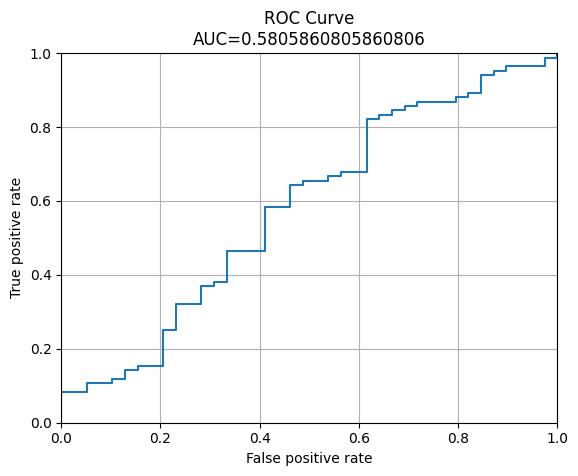

In [39]:
logreg_poly=LogisticRegression()
model_training(logreg_poly,x_train_poly,y_train)

plot_auc_curve(logreg_poly,x_test_poly,y_test)
Find_Optimal_Cutoff(logreg_poly,x_test_poly,y_test)
print_accuracy_metrics(logreg_poly,x_test_poly,y_test,0.75)

RANDOM FOREST

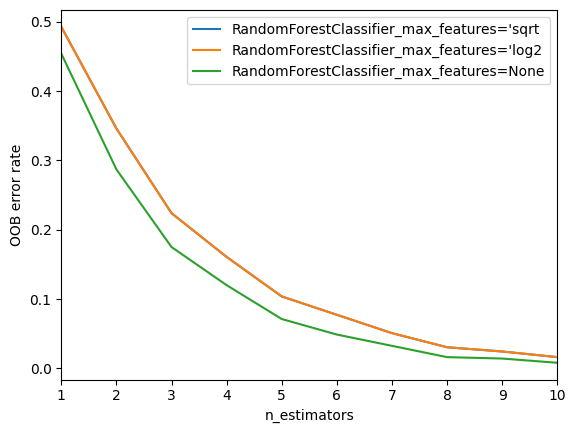

In [50]:
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE=123
x=x_train
y=y_train

ensemble_clfs= [
    ("RandomForestClassifier_max_features='sqrt",RandomForestClassifier(n_estimators=100,warm_start=True,oob_score=True,max_features="sqrt",random_state=RANDOM_STATE)),
    ("RandomForestClassifier_max_features='log2",RandomForestClassifier(n_estimators=100,warm_start=True,oob_score=True,max_features="log2",random_state=RANDOM_STATE)),
    ("RandomForestClassifier_max_features=None", RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True, max_features=None, random_state=RANDOM_STATE))


]

error_rate=OrderedDict((label,[]) for label, _ in ensemble_clfs)

min_estimators=1
max_estimators=10

for label,clf in ensemble_clfs:
  for i in range(min_estimators,max_estimators + 1,1):
    clf.set_params(n_estimators=i)
    clf.fit(x,y)

    oob_error=1-clf.oob_score_
    error_rate[label].append((i,oob_error))

for label,clf_err in error_rate.items():
  xs,ys= zip(*clf_err)
  plt.plot(xs,ys,label=label)

plt.xlim(min_estimators,max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()






(491, 120)
(123, 120)
optimal cutoff [0.95]
Accuracy: 1.0
AUC: 1.0
Log Loss: 0.005830740387826754
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


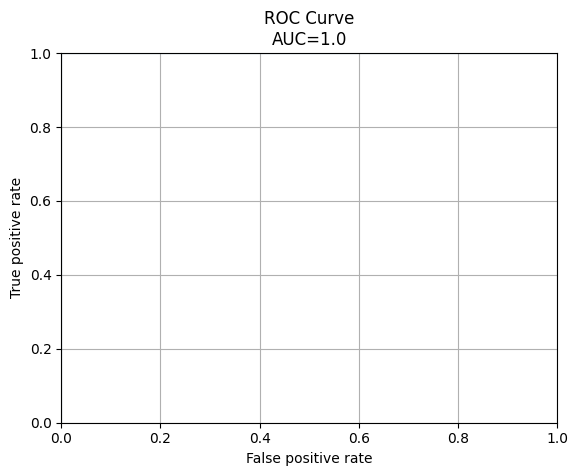

In [53]:
from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=2)

# Transform training data
x_train_poly = poly.fit_transform(x_train)

# Transform test data using the same transformer
x_test_poly = poly.transform(x_test)

# Verify the dimensionality
print(x_train_poly.shape)
print(x_test_poly.shape)

# Now you can use the RandomForestClassifier on the test data
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt', n_jobs=-1)
model_training(rf, x_train_poly, y_train)
plot_auc_curve(rf, x_test_poly, y_test)
Find_Optimal_Cutoff(rf, x_test_poly, y_test)
print_accuracy_metrics(rf, x_test_poly, y_test, 0.73)


optimal cutoff [0.99]
Accuracy: 1.0
AUC: 1.0
Log Loss: 8.171004758966293e-05
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


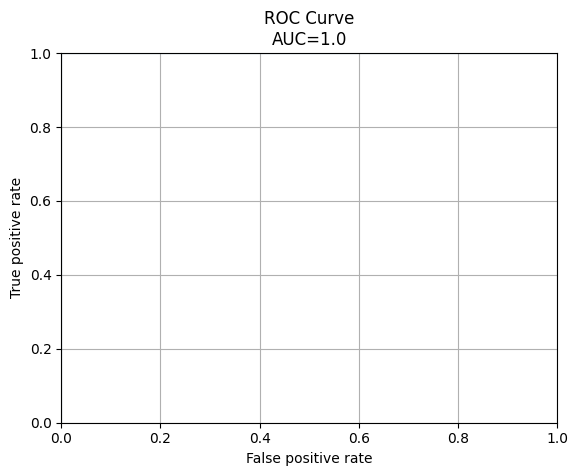

In [55]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_features=None, n_jobs=-1)
model_training(rf, x_train_poly, y_train)
plot_auc_curve(rf, x_test_poly, y_test)
Find_Optimal_Cutoff(rf, x_test_poly, y_test)
print_accuracy_metrics(rf, x_test_poly, y_test, 0.73)

Bagging

optimal cutoff [1.]
Accuracy: 1.0
AUC: 1.0
Log Loss: 2.2204460492503136e-16
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


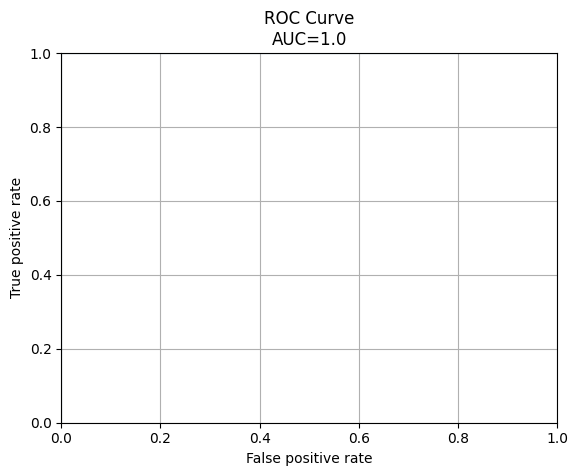

In [57]:
bagging = RandomForestClassifier(n_estimators=10, criterion='gini', max_features=None, n_jobs=-1)
model_training(bagging, x_train_poly, y_train)
plot_auc_curve(bagging, x_test_poly, y_test)
Find_Optimal_Cutoff(bagging, x_test_poly, y_test)
print_accuracy_metrics(bagging, x_test_poly, y_test, 0.73)

Boosting

optimal cutoff [0.99]
Accuracy: 1.0
AUC: 1.0
Log Loss: 8.171004758966293e-05
Confusion Matrix:
 [[39  0]
 [ 0 84]]
Recall: 1.0
Precision: 1.0


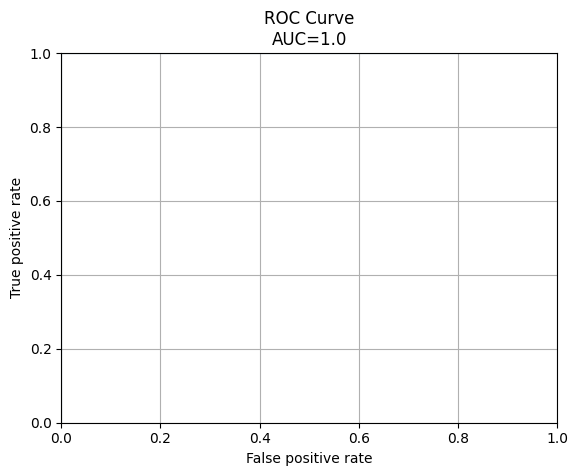

In [59]:
AdaBoost= RandomForestClassifier(n_estimators=100, criterion='gini', max_features=None, n_jobs=-1)
model_training(AdaBoost, x_train_poly, y_train)
plot_auc_curve(AdaBoost, x_test_poly, y_test)
Find_Optimal_Cutoff(AdaBoost, x_test_poly, y_test)
print_accuracy_metrics(AdaBoost, x_test_poly, y_test, 0.73)

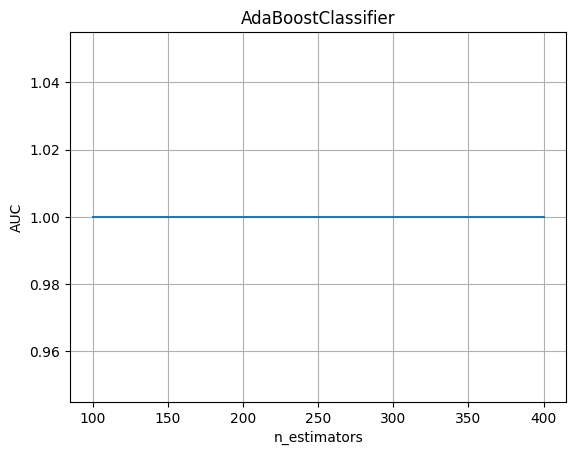

In [63]:
n_range=np.arange(100,500,100)
scores=[]

for n in n_range:
  adaBoost=AdaBoostClassifier(n_estimators=n)
  scores.append(cross_val_score(adaBoost,x_train,y_train,cv=5,scoring='roc_auc').mean())

plt.plot(n_range,scores)
#plt.xlim([0.0],500)
plt.title('AdaBoostClassifier')
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.grid(True)